## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  


In [1]:
# load in packages
from itertools import combinations


import numpy as np
import pandas as pd

import scipy as sp
import sklearn as sk
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize
from statsmodels.stats.power import NormalIndPower

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline


In [2]:
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings


In [3]:
# load in the data
train_data = pd.read_csv('../data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [4]:
#Check overall shape of the data
n_obs = train_data.shape[0]

print("No. of rows in training data: ", n_obs)
print("No. of columns in training data: ", train_data.shape[1])

No. of rows in training data:  84534
No. of columns in training data:  10


In [5]:
#Checking the number of people in control and experiment group

non_promotion_group = train_data[(train_data.Promotion == "No")]
promotion_group = train_data[(train_data.Promotion == "Yes")]

n_control = non_promotion_group.shape[0]
n_treatment = promotion_group.shape[0]
obs_diff = (n_treatment - n_control)/train_data.shape[0]

print("No. of people in Control group: ", n_control)
print("No. of people in Treatment group: ", n_treatment)
print("average difference in group: ", obs_diff)


No. of people in Control group:  42170
No. of people in Treatment group:  42364
average difference in group:  0.002294934582534838


In [6]:
#statistics
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [7]:
# mean purchase rate for customer who received promotion

train_data[train_data.Promotion == "Yes"].purchase.mean()

0.017019167217448776

### Skewed Dataset

When dealing with imbalanced datasets, such as our case where only 1.7% of the experimental group made a purchase, a model that predicts no one will make a purchase would still be correct 98.3% of the time. This results in a high accuracy of 98.3%, but it's misleading because it fails to identify the minority class (purchasers). To address this issue, techniques like oversampling the minority class can be employed. We will handle this imbalance later.

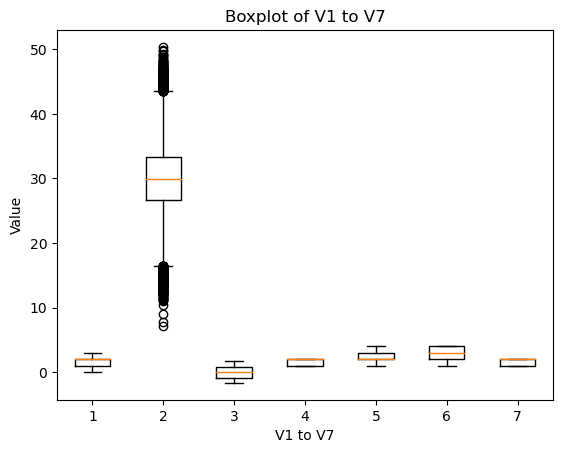

In [8]:
# Create a boxplot of features
fig, ax = plt.subplots()
ax.boxplot(train_data[["V1", "V2", "V3", "V4", "V5", "V6", "V7"]])

# Set the title and axis labels
ax.set_title("Boxplot of V1 to V7")
ax.set_xlabel("V1 to V7")
ax.set_ylabel("Value")

# Show the plot
plt.show()

* As one can observe, V2 features has some outliers

In [9]:
# Calculate the z-scores for the 'V2' feature
z_scores = (train_data["V2"] - train_data["V2"].mean()) / train_data["V2"].std()

# Define the threshold for identifying outliers
threshold = 3

# Identify indices where the absolute value of z-scores is greater than the threshold
outlier_ind = np.where(np.abs(z_scores) > threshold)

# Calculate the ratio of outliers to the total number of observations
ratio_outlier = len(outlier_ind[0]) / train_data['V2'].shape[0]

print(f"Ratio of Outliers in 'V2': {ratio_outlier:.4f}")


Ratio of Outliers in 'V2': 0.0028



## 1) Calculating the Minimum Sample Size: Power Analysis

Although this assignment does not specify a practical significance level, we can use the current purchase rates (p1 and p2) as a baseline. By setting our significance level $\alpha=.05$, and $\beta=.20$ which makes our desired power (1 - β) at 0.80, we can determine if our sample size is sufficiently large to support the conclusions drawn from the A/B testing.

In [10]:
# Calculate the total number of purchases in the treatment group
purch_treat = train_data[train_data['Promotion'] == 'Yes']['purchase'].sum()

# Calculate the total number of customers in the treatment group
cust_treat = train_data.groupby('Promotion').size()[1]

# Calculate the total number of purchases in the control group
purch_ctrl = train_data[train_data['Promotion'] == 'No']['purchase'].sum()

# Calculate the total number of customers in the control group
cust_ctrl = train_data.groupby('Promotion').size()[0]

In [11]:
# define alpha and beta
alpha = 0.05
beta = 0.20
power = 1 - beta

# calculate purchase rate from group 1 and group 2 as baseline
purch_rate_treat = purch_treat / n_treatment
purch_rate_ctrl = purch_ctrl / n_control
print(
    f"""
Purchase Rate of Control: {purch_rate_ctrl}
Purchase Rate of Treatment: {purch_rate_treat}
Purchase Rate Diff : {purch_rate_treat - purch_rate_ctrl }
"""
)


Purchase Rate of Control: 0.007564619397676073
Purchase Rate of Treatment: 0.017019167217448776
Purchase Rate Diff : 0.009454547819772702



In [12]:
# power analysis for sample size
power_analysis = NormalIndPower()
power_analysis.solve_power(
    effect_size=proportion_effectsize(purch_rate_treat, purch_rate_ctrl),
    alpha=alpha,
    power=power,
    alternative="larger",
)

1615.3610613913452

#### 1) Conclusion
$cust_{ctrl} = 42170 > 1616, cust_{treat} = 42364 > 1616$. we can confidently conduct A/B testing. The sample sizes are large enough to ensure the robustness of our results and support our conclusions.



## 2) Invariant Metrics for Experiment Validation

* My initial step will be to analyze the invariant metric of participant numbers in our control and experimental groups

#### Thus, our null and alternative hypotheses are as follows:

$$H_{null} = Customer_{treatment} - Customer_{control} = 0$$
$$H_{alternative} = Customer_{treatment} - Customer_{control} \neq 0$$
$$ Alpha  (\alpha) = 0.05 $$

### Bootstrapping Approach

In [13]:
#Bootstrapping to generate samples

avg_diff = []

for _ in range(10000):
    samples = train_data.sample(25000, replace = True)
    treatment_avg = (samples['Promotion'] == 'Yes').mean()
    control_avg = (samples['Promotion'] == 'No').mean()
    avg_diff.append(treatment_avg - control_avg)

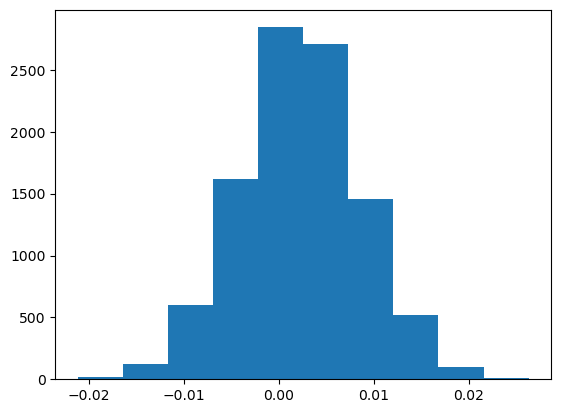

In [14]:
#Visualization of average differences
plt.hist(avg_diff);

* As we can see it closely resembles normal distribution

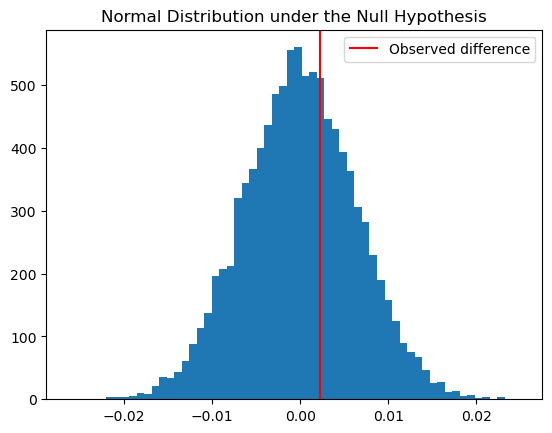

In [15]:
#simulate and visualize differences under null hypothesis with vertical line (observed difference)

avg_null_diff  = np.random.normal(0, np.std(avg_diff), 10000)
plt.hist(avg_null_diff, bins = 60)
plt.axvline(obs_diff, color = 'r', label = 'Observed difference')
plt.legend(loc='upper right')
plt.title("Normal Distribution under the Null Hypothesis");

* Our observed statistic line looks well under 95% confidence interval

In [16]:
p_value = (avg_null_diff <= obs_diff).mean()
print("P-value under boostraping approach: ", p_value)

P-value under boostraping approach:  0.6426


### Simulation Approach with Binomial distribution

In [17]:
# # simulate outcomes under null, compare to observed outcome
p = 0.5
n_obs = train_data.shape[0]
n_simulations = 200_000

sim_samples = np.random.binomial(n_obs, p, n_simulations)

p_value = np.logical_or(sim_samples <= n_control, sim_samples >= n_treatment).mean()
print("P-value under binomial simulation approach: ", p_value)

P-value under binomial simulation approach:  0.50525


#### 2) Conclusion

As we can see our P-value is well within confidence interval, we do not have sufficient evidence to conclude that there is a difference in proportions between the control and treatment groups.

## 3) Analyzing Incremental Response Rate (IRR)

We will assess the experiment's effectiveness in influencing the IIR metric.

Outlined below are the hypotheses guiding our analysis:

$$H_{0}:Incremental Response Rate = 0$$
$$H_{a}:Incremental Response Rate > 0$$


Our *Alpha value* with the Bonferroni Correction:
$$Bonferroni Correction = \frac{\alpha}{number-of-measures} = 0.025$$
$$\alpha = 0.025$$

Where:
$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

In [18]:
# Calculate the total number of purchases in the treatment group
purch_treat = train_data[train_data['Promotion'] == 'Yes']['purchase'].sum()

# Calculate the total number of customers in the treatment group
cust_treat = train_data.groupby('Promotion').size()[1]

# Calculate the total number of purchases in the control group
purch_ctrl = train_data[train_data['Promotion'] == 'No']['purchase'].sum()

# Calculate the total number of customers in the control group
cust_ctrl = train_data.groupby('Promotion').size()[0]

# Compute the Incremental Response Rate (IRR)
IRR = (purch_treat/cust_treat) - (purch_ctrl/cust_ctrl)

In [19]:
IRR

0.009454547819772702

In [20]:
# Initialize a list to store IRR samples
IRR_samples = []

# Generate 10,000 bootstrap samples
for _ in range(10000):
    # Sample 25,000 observations with replacement
    samples = train_data.sample(25000, replace=True)
    
    # Calculate purchases and customers for treatment and control groups in the sample
    sample_purch_treat = samples[samples['Promotion'] == 'Yes']['purchase'].sum()
    sample_cust_treat = samples.groupby('Promotion').size()[1]
    sample_purch_ctrl = samples[samples['Promotion'] == 'No']['purchase'].sum()
    sample_cust_ctrl = samples.groupby('Promotion').size()[0]
    
    # Compute IRR for the sample and append to the list
    IRR_sample = (sample_purch_treat/sample_cust_treat) - (sample_purch_ctrl/sample_cust_ctrl)
    IRR_samples.append(IRR_sample)

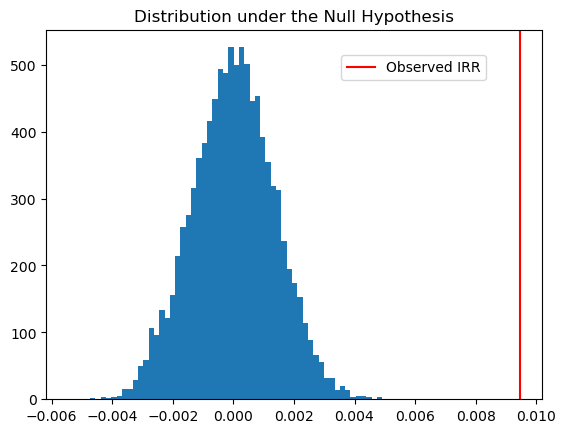

In [21]:
# Generate null distribution of IRR
null_IRR = np.random.normal(0, np.std(IRR_samples), 10000)

# Plot histogram and observed IRR
plt.hist(null_IRR, bins=60)
plt.axvline(IRR, color='r', label='Observed IRR')

# Adjust legend and title
plt.legend(loc='upper right', bbox_to_anchor=(0.90, 0.95))
plt.title("Distribution under the Null Hypothesis");

* Our observed statistical IRR looks very extreme well beyong the confidence interval.

In [22]:
# Compute P value

p_value = (null_IRR > IRR).mean()
p_value

0.0

#### 3) Conclusion
* Our p-value is extremely small, indicating almost a 0% chance of the observed results occurring under the null hypothesis. Therefore, we reject the null hypothesis. 
* This implies a statistically significant increase in IRR between our control and experimental groups. 
* Consequently, we conclude that our campaign has a positive effect on the number of customers who purchased the product with the promotion, compared to those who did not receive the promotion.

## 4) Analyzing Net Incremental Revenue (NIR)

Now, we will assess the experiment's effectiveness in influencing the NIR metric.

Outlined below are the hypotheses guiding our analysis:

$$H_{0}:Net Incremental Revenue = 0$$
$$H_{a}:Net Incremental Revenue > 0$$


Our *Alpha value* with the Bonferroni Correction:
$$Bonferroni Correction = \frac{\alpha}{number-of-measures} = 0.025$$
$$\alpha = 0.025$$

Where:
$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [23]:
# Calculate total purchases in the treatment group
purch_treat = train_data[train_data['Promotion'] == 'Yes']['purchase'].sum()

# Calculate total customers in the treatment group
cust_treat = train_data.groupby('Promotion').size()[1]

# Calculate total purchases in the control group
purch_ctrl = train_data[train_data['Promotion'] == 'No']['purchase'].sum()

# Calculate Net Incremental Revenue (NIR) using given formula
NIR = (10 * purch_treat - 0.15 * cust_treat) - 10 * purch_ctrl

In [24]:
NIR

-2334.5999999999995

In [25]:
# Initialize an empty list to store NIR samples
NIR_samples = []

# Perform bootstrapping to generate 10,000 samples
for _ in range(10000):
    # Sample 25,000 observations with replacement from the original data
    samples = train_data.sample(25000, replace=True)
    
    # Calculate purchases and customers for treatment and control groups in the sample
    sample_purch_treat = samples[samples['Promotion'] == 'Yes']['purchase'].sum()
    sample_cust_treat = samples.groupby('Promotion').size()[1]
    sample_purch_ctrl = samples[samples['Promotion'] == 'No']['purchase'].sum()
    
    # Compute NIR for the sample and append to the list
    NIR_sample = (10 * sample_purch_treat - 0.15 * sample_cust_treat) - 10 * sample_purch_ctrl
    NIR_samples.append(NIR_sample)

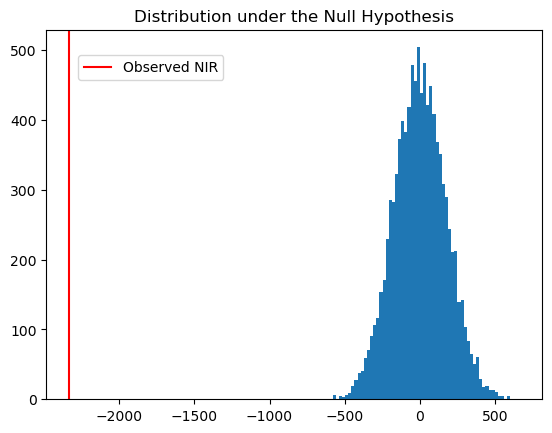

In [26]:
# Generate null distribution of NIR using a normal distribution
null_NIR = np.random.normal(0, np.std(NIR_samples), 10000)

# Plot histogram and observed NIR
plt.hist(null_NIR, bins=60)
plt.axvline(NIR, color='r', label='Observed NIR')

# Adjust legend and title
plt.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))
plt.title("Distribution under the Null Hypothesis");

In [27]:
# Compute P vale

p_value = (null_NIR > NIR).mean()
p_value

1.0

#### 4) Conclusion

Regarding our hypothesis, we aimed to determine if there was a positive impact on NIR. However, as shown in the graph, the observed value falls well behind the null distribution. Therefore, there is no evidence to reject the null hypothesis.

## 5) Modeling

* With our statistical analysis finished, our next step is to develop a model that accurately predicts how customers respond to the campaign, using it to further explore and validate our findings

In [28]:
# evaluation function from Starbucks
def score(df, promo_pred_col = 'Promotion'):
    n_treat       = df.loc[df[promo_pred_col] == 'Yes',:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 'No',:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 'Yes', 'purchase'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 'No', 'purchase'].sum()
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    return (irr, nir)
    
# evaluation function from Starbucks
def test_results(promotion_strategy):
    test_data = pd.read_csv('https://raw.githubusercontent.com/ZacksAmber/Starbucks/main/data/Test.csv')
    df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    promos = promotion_strategy(df)
    score_df = test_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
    print("Nice job!  See how well your strategy worked on our test data below!")
    print()
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    
    print("We came up with a model with an irr of {} and an nir of {} on the test set.\n\n How did you do?".format(0.0188, 189.45))
    return irr, nir

In [29]:
#Training data

train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [30]:
# if we send out promotions to all of the customers

def promotion_strategy(df):
    
    promotion = np.array(['Yes'] * df.shape[0])
    
    
    return promotion

In [31]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

all_irr, all_nir = test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


In [32]:
# Baseline IRR and NIR when we sent promotion randomly

print("IRR: ", IRR)
print("NIR: ", NIR)

IRR:  0.009454547819772702
NIR:  -2334.5999999999995


With every customer receiving a promotion, the IRR remains nearly the same at 0.0096, which is expected since the promotions were randomly assigned in the sample dataset. Although we managed to increase the NIR to -$1132.20, it is still negative, indicating that the current promotion strategy is not effective in improving the NIR. Therefore, we should not pursue this promotion strategy. Instead, we can leverage Machine Learning to develop a better promotion strategy that yields a higher IRR and NIR

## Feature Selection
* We will utilize available features from "V1" to "V7" for our machine learning model, similar to the approach Starbucks employs for evaluation


## Model Selection

* The target variable, purchase, is labeled data, making supervised learning the ideal approach. Given that purchase is a boolean variable, a classifier is needed for this classification task. 
* I have chosen three widely used classification algorithms— **Random Forest Classifier, Logistic Regression and XGBoost Classifier -** —as model baselines, employing default settings and a fixed random state.

In [33]:
pd.read_csv("../reports/baselines/model_baseline.csv")

,Model,IRR,NIR
0,Random Forest Classifier,0.000000,-2.4
1,Logistic Regression,0.014738,-32.4
2,XGBoost Classifier,0.018874,56.0


## Performance Metric Selection

Having selected our ML model, it's essential to choose the right metrics for evaluating its performance. We will refer to our previous analysis in the Data/Business Understanding section to guide this decision.

### Predicted vs. Actual Promotion Outcomes

<table>
<tr><th></th><th colspan='2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

### Customer Categories Based on Model Predictions

| Category | Description | Promotion Sent | Purchase Made | Net Profit (\$) |
|:---:|:---:|:---:|:---:|:---:|
| I | True Positive (TP) | Yes | Yes | 9.00 |
| II | False Positive (FP) | Yes | No | -0.50 |
| III | False Negative (FN) | No | Yes | 10.00 |
| IV | True Negative (TN) | No | No | 0.00 |

**Descriptions:**

**Type I (True Positive):** We correctly predict that a customer will make a purchase and send them a promotion. The customer makes a purchase, validating the effectiveness of our promotion strategy.

**Type II (False Positive):** We predict that a customer will make a purchase and send them a promotion, but the customer does not make a purchase. Reducing False Positives is crucial as they negatively impact Net Profit.

**Type III (False Negative):** We predict that a customer will not make a purchase and refrain from sending a promotion, but the customer ends up making a purchase. Identifying these cases helps in targeting potential customers better.

**Type IV (True Negative):** We correctly predict that a customer will not make a purchase and do not send a promotion. The customer does not make a purchase, aligning with our prediction.

To optimize our model for the best business outcomes, we focus on the following key metrics:

- **Recall Score (TPR):** $\displaystyle \frac{TP}{TP + FN}$
- **Precision Score (PPV):** $\displaystyle \frac{TP}{TP + FP}$
- **Treat Score:** A custom metric to evaluate overall effectiveness

### Summary

We aim to enhance either the TP rate or reduce the FP rate to positively impact key business metrics such as **IRR** and **NIR**. 

- **Recall Score (TPR):** $\displaystyle \frac{TP}{TP + FN}$
- **Precision Score (PPV):** $\displaystyle \frac{TP}{TP + FP}$
- **Treat Score:** $\displaystyle \frac{TP}{TP + FN + FP}$

Additionally, we will establish baselines using common metrics such as accuracy, ROC AUC, and F1 score. For this project, three custom scorers—`irr_score`, `nir_score`, and `irr_nir_score`—are developed to approximate IRR and NIR without causing data leakage.


In [34]:
# define treat score, see https://en.wikipedia.org/wiki/Confusion_matrix
def treat_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn + fp)


# define irr score
def irr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fp) - fn / (fn + tn)


# define nir score
def nir_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (10 * tp - 0.15 * (tp + fp)) - 10 * fn


# combine irr score and nir score together
def irr_nir_score(y_true, y_pred):
    irr = irr_score(y_true, y_pred)
    nir = nir_score(y_true, y_pred)
    return irr * nir

The [Metric_Baseline](../notebooks/Metric_Baseline.ipynb) notebook tunned a XGBClassifier 500 rounds per metric for making the metric baseline. The results are in `../reports/baselines/metric_baseline.csv`.

Next, we will tune the model with the top three metrics of NIR - irr_score, treat_score, and roc_auc.

In [35]:
metric_baseline = pd.read_csv("../reports/baselines/metric_baseline.csv").sort_values(
    "nir", ascending=False
)
metric_baseline = metric_baseline.reset_index(drop=True)
metric_baseline

,scoring,score,irr,nir,n_promotions,n_trials,best_params
0,"make_scorer(irr_score, response_method='predict')",0.017762,0.020606,519.65,19101,500,"{'max_depth': 3, 'learning_rate': 0.0183463400..."
1,roc_auc,0.653748,0.020099,464.70,18739,500,"{'max_depth': 4, 'learning_rate': 0.0100143392..."
2,f1,0.050820,0.019597,416.55,18553,500,"{'max_depth': 3, 'learning_rate': 0.0295476606..."
3,"make_scorer(treat_score, response_method='pred...",0.025944,0.019763,415.75,17907,500,"{'max_depth': 3, 'learning_rate': 0.0193394409..."
4,precision,0.026520,0.019668,394.45,17401,500,"{'max_depth': 3, 'learning_rate': 0.0325975613..."
5,"make_scorer(irr_nir_score, response_method='pr...",2.432661,0.018437,394.30,23361,500,"{'max_depth': 1, 'learning_rate': 0.0463310264..."
6,"make_scorer(nir_score, response_method='predict')",132.760000,0.017863,321.70,23166,500,"{'max_depth': 1, 'learning_rate': 0.0736641572..."
7,accuracy,0.947774,0.015825,10.25,2116,500,"{'max_depth': 7, 'learning_rate': 0.0977444529..."
8,recall,0.855563,0.014231,-107.90,28355,500,"{'max_depth': 1, 'learning_rate': 0.0229251660..."



## Model Tunning

The [Model_Tuning](../notebooks/Model_Tuning.ipynb) notebook tunned a XGBClassifier 5,000 rounds per metric for the top 3 metrics. As we already have some model with good performance, we can narrow down the tuning directions from those hyperparameters from `../reports/baselines/metric_baseline.csv`. The results are in `../reports/tuning_results/model_tuning.csv`.

In [36]:
model_tuning = pd.read_csv("../reports/tuning_results/model_tuning.csv").sort_values(
    "nir", ascending=False
)
model_tuning

,scoring,score,irr,nir,n_promotions,n_trials,best_params
1,f1,0.051305,0.020381,497.30,18977,5000,"{'max_depth': 3, 'learning_rate': 0.0258060210..."
2,"make_scorer(irr_score, response_method='predict')",0.017763,0.020216,460.70,18300,5000,"{'max_depth': 3, 'learning_rate': 0.0158947161..."
0,roc_auc,0.654770,0.019731,451.25,19572,5000,"{'max_depth': 4, 'learning_rate': 0.0100036811..."


The results indicate that following 5,000 rounds of model tuning, the score improved.

In [37]:
_df1 = metric_baseline.loc[:3, ["scoring", "score"]]
_df2 = model_tuning[["scoring", "score"]]
_df = pd.merge(_df1, _df2, on="scoring")
_df.rename(columns={"score_x": "basic score", "score_y": "tuned score"}, inplace=True)
_df["diff"] = _df["tuned score"] - _df["basic score"]
_df["ratio"] = _df["tuned score"] / _df["basic score"]
_df

,scoring,basic score,tuned score,diff,ratio
0,"make_scorer(irr_score, response_method='predict')",0.017762,0.017763,5.853362e-07,1.000033
1,roc_auc,0.653748,0.654770,1.022861e-03,1.001565
2,f1,0.050820,0.051305,4.853042e-04,1.009549


However, there was a slight decline in the **NIR** score. On the other hand, the **F1** metric exhibited a significant increase in the **NIR** score compared to our baseline metric.

It's important to understand that this does not mean the scorers are inversely related to **IRR** and **NIR**. The relationship is more complex and can be best described as a curve, where the goal is to identify an optimal balance point.


In [38]:
_df1 = metric_baseline.loc[:3, ["scoring", "irr", "nir"]]
_df2 = model_tuning[["scoring", "irr", "nir"]]
_df = pd.merge(_df1, _df2, on="scoring")
_df.rename(
    columns={
        "irr_x": "basic irr",
        "irr_y": "tuned irr",
        "nir_x": "basic nir",
        "nir_y": "tuned nir",
    },
    inplace=True,
)
_df["irr diff"] = _df["tuned irr"] - _df["basic irr"]
_df["irr ratio"] = _df["tuned irr"] / _df["basic irr"]
_df["nir diff"] = _df["tuned nir"] - _df["basic nir"]
_df["nir ratio"] = _df["tuned nir"] / _df["basic nir"]
_df = _df[
    [
        "scoring",
        "basic irr",
        "tuned irr",
        "irr diff",
        "irr ratio",
        "basic nir",
        "tuned nir",
        "nir diff",
        "nir ratio",
    ]
]
_df

,scoring,basic irr,tuned irr,irr diff,irr ratio,basic nir,tuned nir,nir diff,nir ratio
0,"make_scorer(irr_score, response_method='predict')",0.020606,0.020216,-0.000390,0.981095,519.65,460.70,-58.95,0.886558
1,roc_auc,0.020099,0.019731,-0.000368,0.981681,464.70,451.25,-13.45,0.971057
2,f1,0.019597,0.020381,0.000783,1.039970,416.55,497.30,80.75,1.193854


In [39]:
# Baseline IRR and NIR when we sent promotion randomly

print("IRR: ", IRR)
print("NIR: ", NIR)

IRR:  0.009454547819772702
NIR:  -2334.5999999999995


In [50]:
metric_baseline.iloc[0]

scoring         make_scorer(irr_score, response_method='predict')
score                                                    0.017762
irr                                                      0.020606
nir                                                        519.65
n_promotions                                                19101
n_trials                                                      500
best_params     {'max_depth': 3, 'learning_rate': 0.0183463400...
Name: 0, dtype: object

In [46]:
best_irr = metric_baseline.iloc[0].irr
best_nir = metric_baseline.iloc[0].nir
print(metric_baseline.loc[0, "best_params"])

{'max_depth': 3, 'learning_rate': 0.018346340063285248, 'n_estimators': 190, 'gamma': 0.4018555699113115, 'subsample': 0.7127760681819945, 'colsample_bytree': 0.6612729951187046, 'reg_alpha': 0.4225060439585793, 'reg_lambda': 7.818764244426856, 'min_child_weight': 180}


In [47]:
df = pd.DataFrame(
    {
        "Label": ["Random-promotion", "All-promotion", "Starbucks-promotion", "Best-promotion"],
        "IRR": [round(IRR, 4), round(all_irr, 4), 0.0188, round(best_irr, 4)],
        "NIR": [round(NIR, 2), round(all_nir, 2), 189.45, round(best_nir, 2)],
    }
)

df

,Label,IRR,NIR
0,Random-promotion,0.0095,-2334.60
1,All-promotion,0.0096,-1132.20
2,Starbucks-promotion,0.0188,189.45
3,Best-promotion,0.0206,519.65


## Visualization

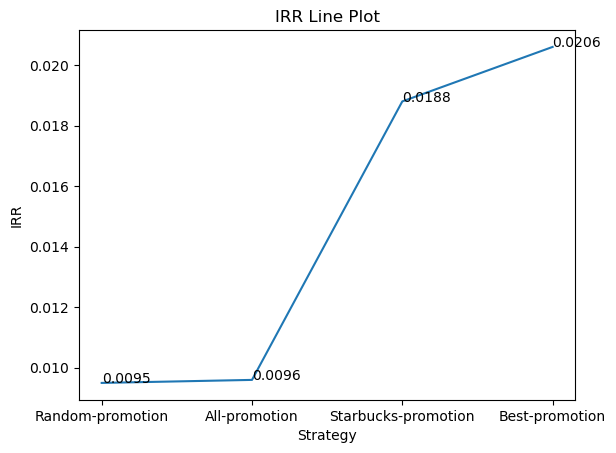

In [48]:
# Create line plot for IRR
x, y = df.Label, df.IRR
plt.plot(x, y)

# Annotate each y value
for i, j in zip(x, y):
    plt.annotate(str(j), xy=(i, j))

# Add x and y axis labels
plt.xlabel("Strategy")
plt.ylabel("IRR")

# Add title
plt.title("IRR Line Plot")

# Save plot
# plt.savefig('irr_line_plot.png')

# Show plot
plt.show()

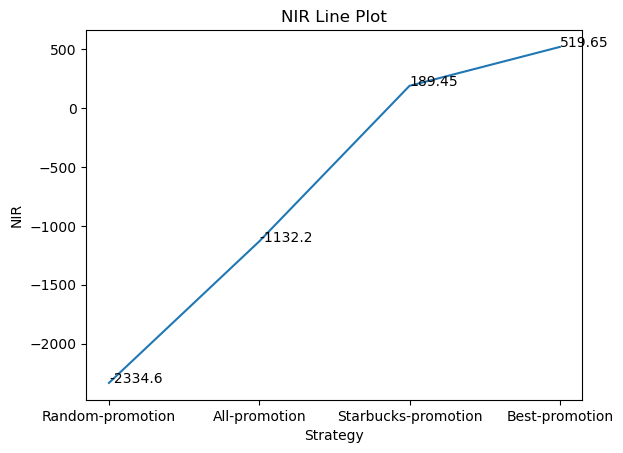

In [49]:
# Create line plot for IRR
x, y = df.Label, df.NIR
plt.plot(x, y)

# Annotate each y value
for i, j in zip(x, y):
    plt.annotate(str(j), xy=(i, j))

# Add x and y axis labels
plt.xlabel("Strategy")
plt.ylabel("NIR")

# Add title
plt.title("NIR Line Plot")

# Save plot
# plt.savefig('nir_line_plot.png')

# Show plot
plt.show()

---

## ML Conclusion

As the the conclusion, I prefer the following ML strategy for maximizing the IRR and NIR:
- Model: XGBoost Classifier
- Features: All
- Metric (custom): $ IRR Score=\frac{tp}{(tp + fp)} - \frac{fn}{(fn + tn)}$ 
- IRR: 0.020606
- NIR: 519.65
- Hyperparameters: `{'max_depth': 3, 'learning_rate': 0.018346340063285248, 'n_estimators': 190, 'gamma': 0.4018555699113115, 'subsample': 0.7127760681819945, 'colsample_bytree': 0.6612729951187046, 'reg_alpha': 0.4225060439585793, 'reg_lambda': 7.818764244426856, 'min_child_weight': 180}`


### Comparative Performance

- `IRR Improvement`: Compared to the **Random-Promotion Strategy** IRR of **0.00945**, our solution achieved an IRR of **0.020606**, representing an increase of **0.011156** or approximately **118%**.
- `NIR Improvement`: Compared to the **Random-Promotion Strategy** NIR of **-2334.599**, our solution achieved an NIR of **519.65**, an increase of **2854.24**.
- `IRR vs. Starbucks Baseline`: Compared to the **Starbucks Baseline** IRR of **0.0188**, our model increased IRR by **0.001806**, or **9.6%**.
- `NIR vs. Starbucks Baseline`: Compared to the **Starbucks Baseline** NIR of **189.45**, our model achieved an NIR of **519.65**, an increase of **330.2**, or **174.29%**.

This model's enhanced performance underscores its potential to drive better financial outcomes and aligns with strategic goals for optimizing promotions and customer engagement.
